In [44]:
import pandas as pd
import pandahouse as ph
import numpy as np
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
from typing import Tuple

In [45]:
connection = {
    'host'      : 'https://clickhouse.lab.karpov.courses',
    'password'  : 'dpo_python_2020',
    'user'      : 'student',
    'database'  : 'simulator_20221020'
}

In [46]:
q = """
select
    user_id,
    exp_group, 
    countIf(action='like') as likes,
    countIf(action='view') as views, 
    likes / views as ctr
from {db}.feed_actions
where toDate(time) >= '2022-10-03' and toDate(time) <= '2022-10-09'
and exp_group in (1, 2)
group by 2, 1
"""

In [47]:
df_ab = ph.read_clickhouse(q, connection=connection)

In [48]:
df_ab

,user_id,exp_group,likes,views,ctr
0,109963,1,3,15,0.200000
1,26117,1,32,141,0.226950
2,138232,1,18,73,0.246575
3,26295,1,33,122,0.270492
4,18392,1,7,32,0.218750
...,...,...,...,...,...
20026,132567,1,45,296,0.152027
20027,30872,1,11,59,0.186441
20028,25383,2,42,127,0.330709
20029,139020,2,24,114,0.210526


In [49]:
group_a = df_ab[df_ab['exp_group'] == 1]['ctr'] # контрольная группа
group_b = df_ab[df_ab['exp_group'] == 2]['ctr'] # экпериментальная группа

In [50]:
 # Установим размер графиков
sns.set(rc={'figure.figsize':(10, 10)})

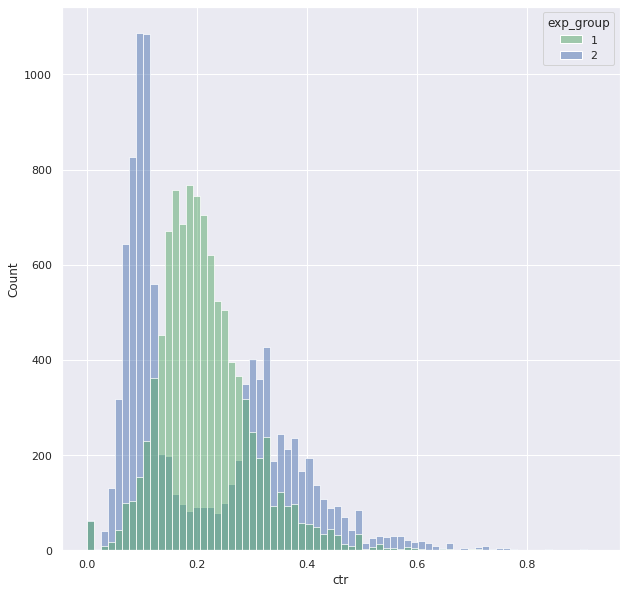

In [51]:
 sns.histplot(data=df_ab,
             x          = 'ctr',
             hue        = 'exp_group',
             palette    = ['g', 'b'],
             kde        = False,
             alpha      = 0.5);

Распределение ctr первой группы напоминает нормальное распределение. Распределение втторой группы бимодальное. Это говорит о том, что в данном случае t-test не дает гарантированного результата.
Можем предположить, что тестовая группа разделилась на 2 подгруппы с негативным и позитивным влиянием на CTR.

# Пременим разные тесты

# Т-тест

In [52]:
 st.ttest_ind(group_a, group_b, equal_var=False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

In [53]:
 group_a.mean(), group_b.mean()

(0.21560459841296287, 0.21441927347479375)

Результат:
p-value > 0.05 поэтому статистически значимого различия нет. Это зависит от того, что распределение ctr второй группы не норм, применение теста не корректно.

# Mann-Witney test

In [54]:
st.mannwhitneyu(group_a, group_b, alternative='two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

Тест Манна Уитни показывает статистические различия

# Smoothed CTR

In [55]:
def get_smoothed_ctr(user_likes: pd.Series,
                     user_views: pd.Series,
                     global_ctr: int,
                     alpha: int = 5
) -> pd.Series:
    smoothed_ctr = (user_likes +  alpha * global_ctr) / (user_views + alpha)
    return smoothed_ctr

In [56]:
 # рассчитаем общий ctr в первой и во второй группах
all_ctr_1 = df_ab[df_ab['exp_group'] == 1]['likes'].sum() / df_ab[df_ab['exp_group'] == 1]['views'].sum()
all_ctr_2 = df_ab[df_ab['exp_group'] == 2]['likes'].sum() / df_ab[df_ab['exp_group'] == 2]['views'].sum()

In [57]:
all_ctr_1, all_ctr_2

(0.20802680490126244, 0.1980601844115994)

In [58]:
group_1 = df_ab[df_ab['exp_group'] == 1]
group_2 = df_ab[df_ab['exp_group'] == 2]

In [61]:
group_1['smoothed_ctr'] = df_ab[df_ab['exp_group'] == 1].apply(lambda x: get_smoothed_ctr(x['likes'], x['views'], all_ctr_1), axis=1)
group_2['smoothed_ctr'] = df_ab[df_ab['exp_group'] == 2].apply(lambda x: get_smoothed_ctr(x['likes'], x['views'], all_ctr_2), axis=1)

/tmp/ipykernel_63/2426916420.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_1['smoothed_ctr'] = df_ab[df_ab['exp_group'] == 1].apply(lambda x: get_smoothed_ctr(x['likes'], x['views'], all_ctr_1), axis=1)
/tmp/ipykernel_63/2426916420.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_2['smoothed_ctr'] = df_ab[df_ab['exp_group'] == 2].apply(lambda x: get_smoothed_ctr(x['likes'], x['views'], all_ctr_2), axis=1)


In [62]:
group_1

,user_id,exp_group,likes,views,ctr,smoothed_ctr
0,109963,1,3,15,0.200000,0.202007
1,26117,1,32,141,0.226950,0.226302
2,138232,1,18,73,0.246575,0.244104
3,26295,1,33,122,0.270492,0.268033
4,18392,1,7,32,0.218750,0.217301
...,...,...,...,...,...,...
20020,31540,1,8,45,0.177778,0.180803
20021,23359,1,23,91,0.252747,0.250418
20024,110956,1,3,16,0.187500,0.192387
20026,132567,1,45,296,0.152027,0.152957


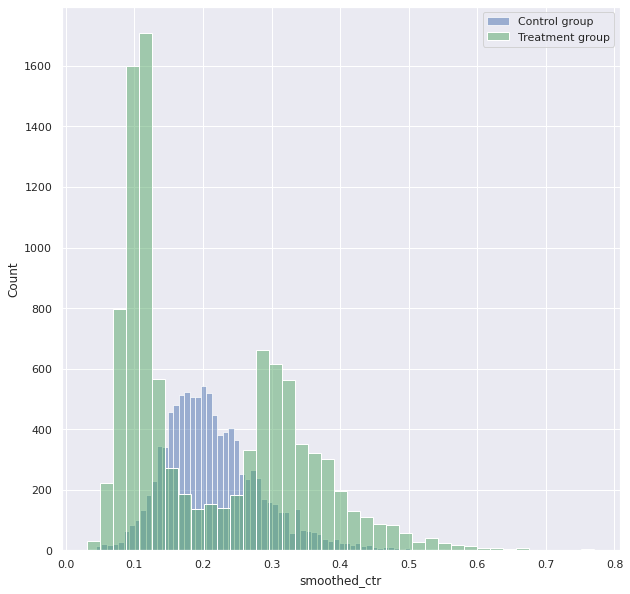

In [66]:
sns.histplot(group_1['smoothed_ctr'],
             color='b',
             alpha=0.5,
             kde=False);
sns.histplot(group_2['smoothed_ctr'],
             color='g',
             alpha=0.5,
             kde=False);
plt.legend(labels=['Control group', 'Treatment group']);

# T-test CTR

In [67]:
st.ttest_ind(group_1['smoothed_ctr'], group_2['smoothed_ctr'], equal_var=False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

In [68]:
# найдем средние в контрольниой и тестовой группах
group_1['smoothed_ctr'].mean(), group_2['smoothed_ctr'].mean()

(0.21402549608884142, 0.21073955503259234)

# Mann-Witney test CTR

In [69]:
st.mannwhitneyu(group_1['smoothed_ctr'], group_2['smoothed_ctr'], alternative='two-sided')

MannwhitneyuResult(statistic=56925125.0, pvalue=1.6163964114270227e-61)

Результат:
    Сглаженный ctr ttest, в отличие от обычного ctr, показывает стат. значимое различие. Тест Манна-Уитни сходится с предыдущим.

# Применим Poisson bootstrap

In [72]:
def poisson_bootstrap(likes1: np.ndarray,
                      views1: np.ndarray,
                      likes2: np.ndarray,
                      views2: np.ndarray,
                      n_bootstrap: int = 10000
) -> Tuple[np.ndarray, np.ndarray]:
    btstrp_samples_1 = st.poisson(1).rvs((n_bootstrap, len(likes1)))
    btstrp_samples_2 = st.poisson(1).rvs((n_bootstrap, len(likes2)))

    global_ctr_1 = (btstrp_samples_1 * likes1).sum(axis=1) / (btstrp_samples_1 * views1).sum(axis=1)
    global_ctr_2 = (btstrp_samples_2 * likes2).sum(axis=1) / (btstrp_samples_2 * views2).sum(axis=1)

    return global_ctr_1, global_ctr_2

In [73]:
likes1 = df_ab[df_ab.exp_group == 1]['likes'].to_numpy()
likes2 = df_ab[df_ab.exp_group == 2]['likes'].to_numpy()
views1 = df_ab[df_ab.exp_group == 1]['views'].to_numpy()
views2 = df_ab[df_ab.exp_group == 2]['views'].to_numpy()

In [74]:
ctr_1, ctr_2  = poisson_bootstrap(likes1, views1, likes2, views2)

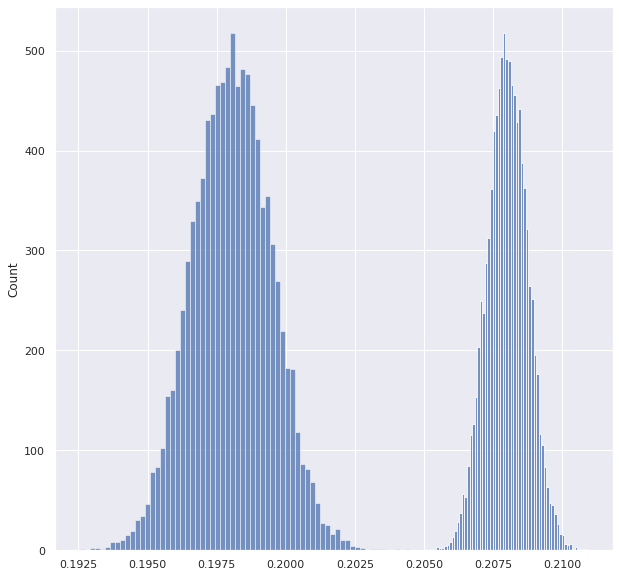

In [75]:
sns.set(rc={'figure.figsize':(10, 10)})
sns.histplot(ctr_1)
sns.histplot(ctr_2);

<AxesSubplot:ylabel='Count'>

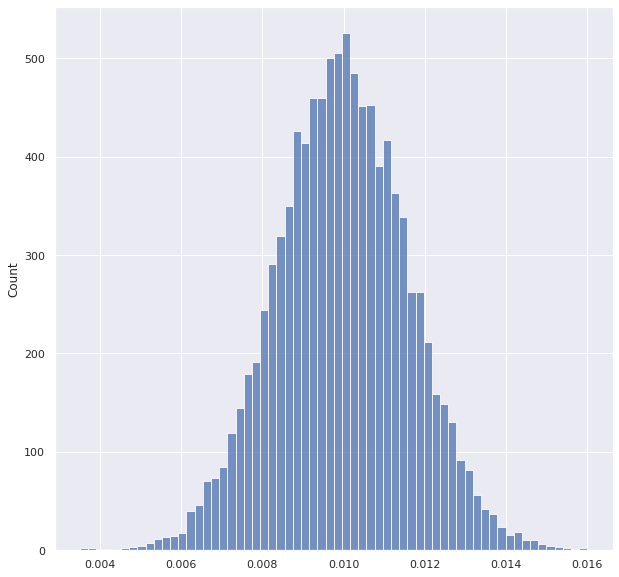

In [76]:
sns.histplot(ctr_1 - ctr_2)

Результат:
    Распределение глобального ctr показывает, что ctr в тестовой группе стал меньше для каждой бустрап-подвыборки

# Бакетное преобразование

In [78]:
q = """
select
  exp_group,
  bucket,
  sum(likes) / sum(views) as bucket_ctr
from
  (
    SELECT
      exp_group,
      xxHash64(user_id) % 50  as bucket,
      user_id,
      sum(action = 'like')    as likes,
      sum(action = 'view')    as views,
      likes / views           as ctr
    FROM
      simulator_20221020.feed_actions
    where
      toDate(time) >= '2022-10-03' and toDate(time) <= '2022-10-09'
      and exp_group in (1, 2)
    GROUP BY 1,2,3
  )
group by 2,1
"""

In [79]:
df_bucket = ph.read_clickhouse(q, connection=connection)
df_bucket

,exp_group,bucket,bucket_ctr
0,1,0,0.196481
1,1,1,0.211887
2,1,2,0.206271
3,1,3,0.203733
4,1,4,0.209739
...,...,...,...
95,2,45,0.179901
96,2,46,0.192589
97,2,47,0.195880
98,2,48,0.194502


# t-test

In [80]:
st.ttest_ind(df_bucket[df_bucket['exp_group'] == 1]['bucket_ctr'],
             df_bucket[df_bucket['exp_group'] == 2]['bucket_ctr'],
             equal_var=False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

#  Mann-Witney test

In [81]:
st.mannwhitneyu(df_bucket[df_bucket['exp_group'] == 1]['bucket_ctr'],
                df_bucket[df_bucket['exp_group'] == 2]['bucket_ctr'],
                alternative='two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

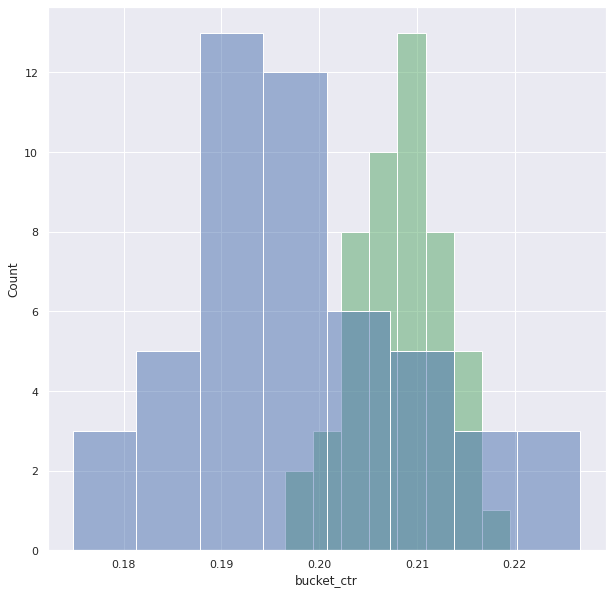

In [84]:
sns.histplot(df_bucket[df_bucket['exp_group'] == 1]['bucket_ctr'],
             color='g',
             alpha=0.5,
             kde=False)
sns.histplot(df_bucket[df_bucket['exp_group'] == 2]['bucket_ctr'],
             color='b',
             alpha=0.5,
             kde=False);

 Вывод: Оба теста показывают статмстически значимое различие, это визуально видно на распределениях (среднее тестовой группы смещено). Распределение бакетного ctr напоминает нормальное.

# Общий вывод

Были проведены тесты: ttest'а Стьюдента и теста Манна-Уитни, кроме этого было применено: сглаживание CTR, Пуассоновский бутстреп, бакетное преобразование. 
По результатам теста видим, что между контрольной и тестовой группами наблюдается стат. значимое различие. Это наблюдается и при сравнении поюзерного CTR, и глобального. Также Пуассоновский бутстрап и бакетное преобразование показали, что в среднем глобальный CTR уменьшился. По результатм теста не рекомендуется раскатывать новый алгоритм на всех пользователей.